In [1]:
import Pkg
Pkg.activate("/Users/markus/.julia/env/ppl")

  Activating project at `~/.julia/env/ppl`


In [2]:
using Turing
import PyPlot
using PyCall

plt = pyimport("matplotlib.pyplot");
plt_image = pyimport("matplotlib.image");
plt_box = pyimport("matplotlib.offsetbox");
plt_cm = pyimport("matplotlib.cm");
plt_lines = pyimport("matplotlib.lines");
np = pyimport("numpy");

In [3]:
slope_true = 2
intercept_true = -1
slope_true, intercept_true

(2, -1)

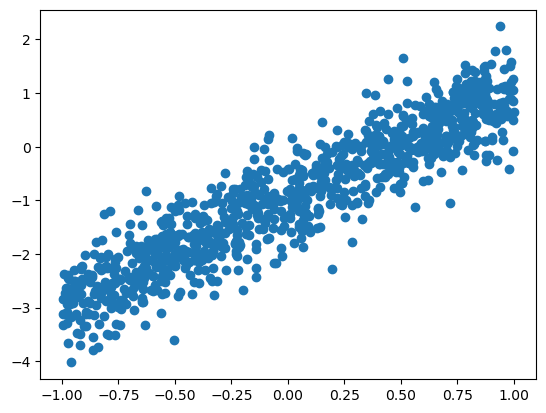

In [4]:
Turing.Random.seed!(0)
xs = rand(Uniform(-1,1),1000)
ys = rand.(Normal.(slope_true .* xs .+ intercept_true, 0.5))
plt.scatter(xs, ys);

In [5]:
broad_prior_params = (slope_mean=0., slope_sigma=3., intercept_mean=0., intercept_sigma=3.);
informative_prior_params = (slope_mean=0, slope_sigma=0.5, intercept_mean=0., intercept_sigma=0.5);

In [6]:
@model function linear_regression(
        x, y;
        slope_mean, slope_sigma,
        intercept_mean, intercept_sigma
    )
    
    # prior over latents
    slope ~ Normal(slope_mean, slope_sigma)
    intercept ~ Normal(intercept_mean, intercept_sigma)
    
    # likelihood
    for i in 1:length(x)
        # y ≈ slope * x + intercept
        y[i] ~ Normal(slope * x[i] + intercept, 1.)
    end
end

linear_regression (generic function with 2 methods)

In [7]:
# just a plotting function
function plot_linreg(x, y, result; alpha, ylims)
    fig, ax = plt.subplots(1,1)
    ax.set_ylim(ylims)
    xs = LinRange(minimum(x)-0.5, maximum(x)+0.5, 100)
    for i in 1:length(result)
        slope = result[:slope][i]
        intercept = result[:intercept][i]
        a = alpha isa AbstractVector ? alpha[i] : alpha
        ax.plot(xs, slope.* xs .+ intercept, color="black", alpha=a)
    end
    ax.scatter(x, y, zorder=length(result)+1, edgecolors="black")
end

plot_linreg (generic function with 1 method)

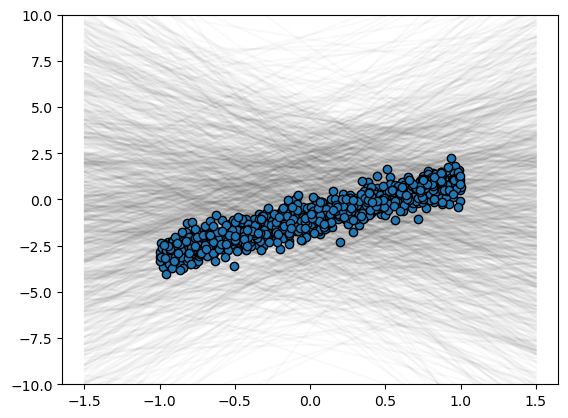

In [8]:
model = linear_regression(xs,ys; broad_prior_params...);
result = sample(model, Prior(), 1000);
plot_linreg(xs, ys, result; alpha=0.025,ylims=(-10,10));

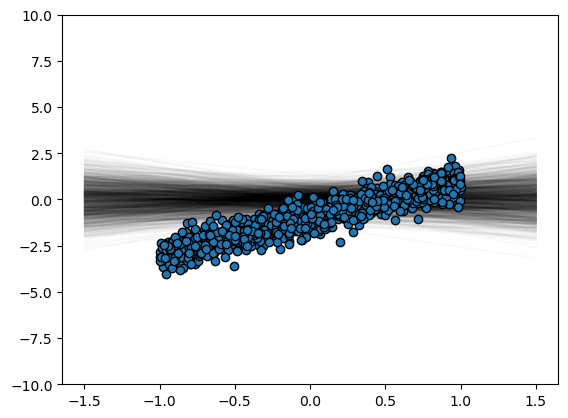

In [9]:
model = linear_regression(xs,ys; informative_prior_params...);
result = sample(model, Prior(), 1000);
plot_linreg(xs, ys, result; alpha=0.025, ylims=(-10,10));

In [10]:
# p(slope, intercept)
function log_linear_regression_prior(
        slope, intercept,
        x, y;
        slope_mean, slope_sigma,
        intercept_mean, intercept_sigma,
    )
    
    lp = 0.
    
    lp += logpdf(Normal(slope_mean, slope_sigma), slope)
    lp += logpdf(Normal(intercept_mean, intercept_sigma), intercept)
    
    return lp
end

# p(data | slope, intercept)
function log_linear_regression_likelihood(
        slope, intercept,
        x, y;
    )
    
    lp = 0.
    
    for i in 1:length(x)
        lp += logpdf(Normal(slope * x[i] + intercept, 1.), y[i])
    end
    
    return lp
end

log_linear_regression_likelihood (generic function with 1 method)

In [11]:
function logsumexp(x)
    m = maximum(x)
    if m == -Inf
        return -Inf
    end
    return log(sum(exp, x .- m)) + m
end

logsumexp (generic function with 1 method)

In [12]:
# just a plotting function
function compare(xs, ys, xmin, xmax, ymin, ymax)
    fig, ax = plt.subplots(ncols=2,figsize=(12,6))
    
    delta = 0.01
    s_range = xmin:delta:xmax
    i_range = ymin:delta:ymax
    S, I = np.meshgrid(s_range, i_range, indexing="xy")
    
    log_z_broad = (slope, intercept) -> log_linear_regression_prior(slope, intercept, xs, ys; broad_prior_params...) + log_linear_regression_likelihood(slope, intercept, xs, ys)
    log_z_informative = (slope, intercept) -> log_linear_regression_prior(slope, intercept, xs, ys; informative_prior_params...) + log_linear_regression_likelihood(slope, intercept, xs, ys)
    
    log_Z_broad = [log_z_broad(s,i) for i in i_range, s in s_range]
    log_Z_broad = log_Z_broad .- logsumexp(log_Z_broad) .- log(delta^2)
    
    log_Z_informative = [log_z_informative(s,i) for i in i_range, s in s_range]
    log_Z_informative = log_Z_informative .- logsumexp(log_Z_informative) .- log(delta^2)
    
    ax[1].contour(S, I, exp.(log_Z_broad), cmap=plt_cm.Blues)
    ax[1].contour(S, I, exp.(log_Z_informative), cmap=plt_cm.Reds)
    ax[1].set_title("#data=$(length(xs))")
    
    legend_elements = [
        plt_lines.Line2D([0], [0], color="tab:red", lw=4, label="informative prior"),
        plt_lines.Line2D([0], [0], color="tab:blue", lw=4, label="broad prior")
    ]
    ax[1].legend(handles=legend_elements)
    
    x_range = -1:delta:1
    
    ax[2].scatter(xs, ys, color="black")
    slope_informative = S[argmax(log_Z_informative)]
    intercept_informative = I[argmax(log_Z_informative)]
    ax[2].plot(x_range, slope_informative .* x_range .+ intercept_informative, color="tab:red")
    
    slope_broad = S[argmax(log_Z_broad)]
    intercept_broad = I[argmax(log_Z_broad)]
    ax[2].plot(x_range, slope_broad .* x_range .+ intercept_broad, color="tab:blue")
end

compare (generic function with 1 method)

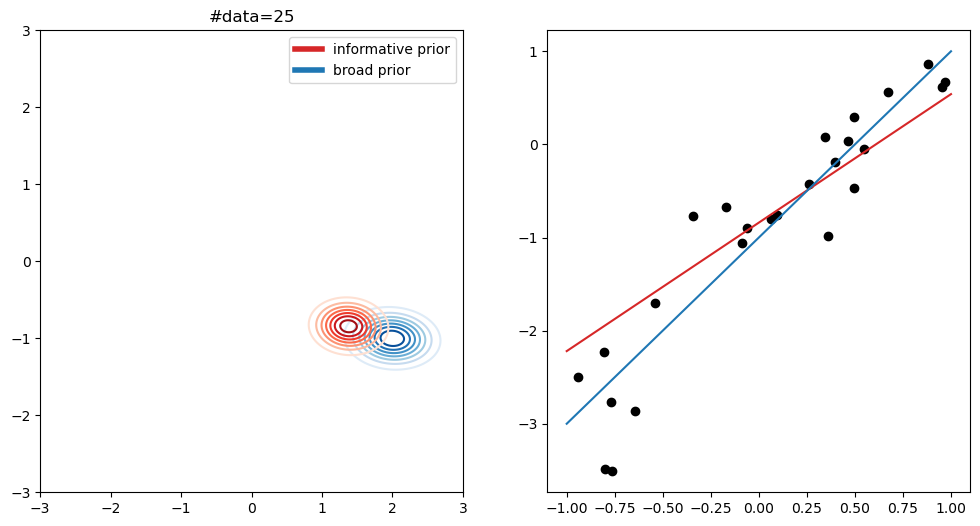

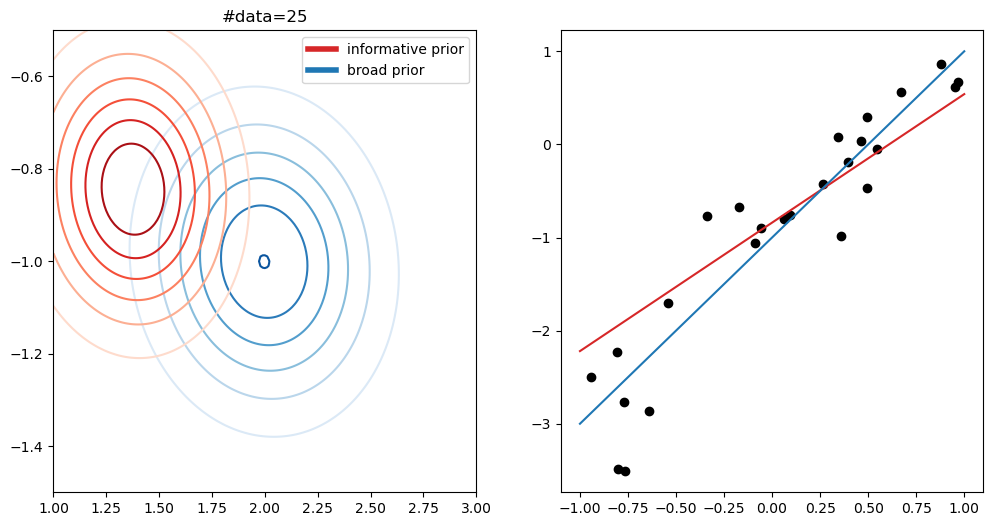

In [13]:
N = 25
compare(xs[1:N], ys[1:N], -3, 3, -3, 3);
compare(xs[1:N], ys[1:N], 1, 3, -1.5, -0.5);